# Kaggle Workflow
As a compendium to the previous "Refining Model Accuracies" project, in this project we'll be creating a streamlined workflow for cyclic exploration, engineering and selection of features and models for our data. Using a few sklearn methods we'll be able to automate the identification and selection of the best features and models as well as the optimal hyperparameter selection. 

The Kaggle contest is the same as the previous one: the goal is to predict whether a test set of passengers embarked on the Titanic survived the sinking of the ship or perished in the [accident](https://en.wikipedia.org/wiki/Sinking_of_the_RMS_Titanic).

In [87]:
import pandas as pd

## Data acquisition and processing

In [88]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [89]:
# Let's take a look at what the holdout dataset looks like
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [90]:
# A set of functions was provided together with the data
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [91]:
# Here we define a function to streamline the processing of our train and holdout datasets
def process_dataframe(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    cols = ["Age_categories","Fare_categories","Title","Cabin_type","Sex","Pclass"]
    for c in cols:
        df = create_dummies(df,c)
    return df

In [92]:
# Dataset processing
train = process_dataframe(train)
holdout = process_dataframe(holdout)

In [93]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 46 columns):
PassengerId                   891 non-null int64
Survived                      891 non-null int64
Pclass                        891 non-null int64
Name                          891 non-null object
Sex                           891 non-null object
Age                           891 non-null float64
SibSp                         891 non-null int64
Parch                         891 non-null int64
Ticket                        891 non-null object
Fare                          891 non-null float64
Embarked                      891 non-null object
Age_categories                891 non-null category
Fare_categories               891 non-null category
Title                         891 non-null object
Cabin_type                    891 non-null object
Age_categories_Missing        891 non-null uint8
Age_categories_Infant         891 non-null uint8
Age_categories_Child          891 non-null uin

## Data exploration
Now that the datasets have been loaded and processed we can start looking into the data itself. For example, let's look into "SibSp" and "Parch" - these columns respectively indicate the number of siblings and/or spouses and the number of children and/or parents each of the passengers had on board.

In [94]:
# Let's copy the relevant columns into a new dataframe
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


In [95]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,0,'Number of relatives')

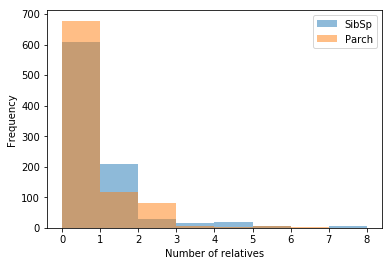

In [96]:
# First of all we look at the distribution of the SibSp and Parch columns
explore.drop("Survived",axis=1).plot.hist(alpha=.5,bins=8)
plt.xlabel("Number of relatives")

Text(0.5,0,'Number of relatives')

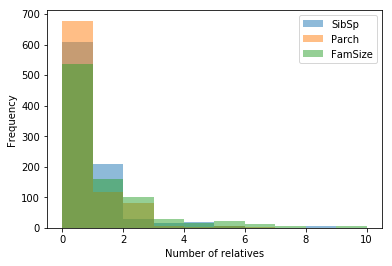

In [97]:
# We can also add a new column representing the total number of relatives each passenger had on board (SibSp + Parch)
explore["FamSize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=.5,bins=10)
plt.xlabel("Number of relatives")

We've picked a few interesting columns and visualized the distribution of their data. Now we can take advantage of the .pivot_table() function and produce pivot tables to visually represent how the number of spouses/siblings, parents/children and relatives in general affected (or not) the survivability of the passengers.

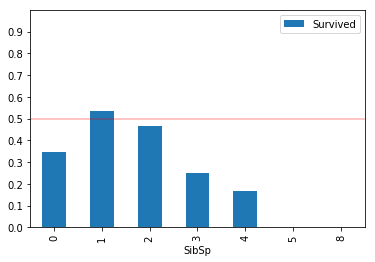

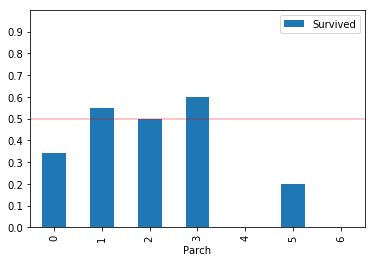

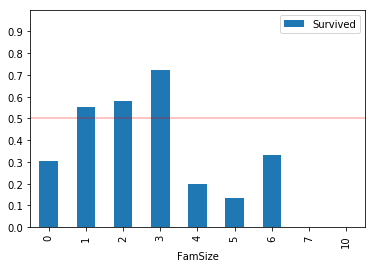

In [98]:
import numpy as np
# We can use a for loop to output one figure for each of the columns
for c in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(values="Survived",index=c)
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhline(.5, alpha=0.3, color='red')

Summing up: as we've seen the SibSp column describes the total number of siblings and/or spouses a passenger had on board, while the Parch column describes the number of parents and/or children a passenger had on board. We further added a third FamSize column to describe the total number of family members a passenger had on board, taken simply as the sum of the SibSp and Parch columns.

In both SibSp and Parch columns (and FamSize as a result) the distribution is skewed to the right, with the majority of passengers having no family members on board.

Exploring pivot tables of our data shows that lone passengers are far more likely to have perished than passengers who had at least one family member on board. This trails off as the total number of family members grows beyond 3. In general, passengers with 1-3 family members on board survived more than 50% of the time (as far as our training dataset goes), with a peak of over 70% survival rate for passengers with exactly 3 family members on board. Only 30% of passengers with no family members survived.

*Let's use this stark contrast in survival rates between passengers with and without family members on board to define a new feature.*

In [99]:
def is_alone(df):
    df["isAlone"] = df[["SibSp","Parch"]].sum(axis=1).apply(lambda x: 1 if x == 0 else 0)
    return df

In [100]:
train = is_alone(train)
holdout = is_alone(holdout)

In [101]:
# Let's also add the FamSize column directly and see which of these two new features will perform best
train["FamSize"] = train[["SibSp","Parch"]].sum(axis=1)
holdout["FamSize"] = holdout[["SibSp","Parch"]].sum(axis=1)

Before we go any further let's also remember to rescale the numeric columns and to then drop old versions of the columns we have engineered. PassengerId and Ticket number are also superfluous.

In [102]:
from sklearn.preprocessing import minmax_scale
columns = ["SibSp_scaled","Parch_scaled","Fare_scaled","FamSize_scaled"]
target_columns = ["SibSp","Parch","Fare","FamSize"]

for i in range(4):
    train[columns[i]] = minmax_scale(train[target_columns[i]])
    holdout[columns[i]] = minmax_scale(holdout[target_columns[i]])

C:\Users\jacop\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [105]:
train = train_backup # Comment this whole line the first time around
keep_columns = train.columns.drop(["SibSp","Parch","Fare","FamSize","Age","Age_categories","Fare_categories","Sex","Pclass","Cabin_type","Title","Name","Ticket","PassengerId"])
train_backup = train
train = train[keep_columns]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 38 columns):
Survived                      891 non-null int64
Embarked                      891 non-null object
Age_categories_Missing        891 non-null uint8
Age_categories_Infant         891 non-null uint8
Age_categories_Child          891 non-null uint8
Age_categories_Teenager       891 non-null uint8
Age_categories_Young Adult    891 non-null uint8
Age_categories_Adult          891 non-null uint8
Age_categories_Senior         891 non-null uint8
Fare_categories_0-12          891 non-null uint8
Fare_categories_12-50         891 non-null uint8
Fare_categories_50-100        891 non-null uint8
Fare_categories_100+          891 non-null uint8
Title_Master                  891 non-null uint8
Title_Miss                    891 non-null uint8
Title_Mr                      891 non-null uint8
Title_Mrs                     891 non-null uint8
Title_Officer                 891 non-null uint8
Title_Royalt

## Feature selection
Now that we've explored the data, let's select the best features. The sklearn.feature_selection.RFECV() class will let us automate this step.

In [106]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression

In [114]:
def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    columns = df.columns.drop(["Survived"]) # We drop the PassengerId since this is just a unique identifier
    all_X = df[columns]                                   # with no further informational bearing
    all_y = df["Survived"]
    rf = RandomForestClassifier()
    selector = RFECV(rf,cv=10)
    selector.fit(all_X,all_y)
    optm_features = all_X.columns[selector.support_]
    print(optm_features)
    return optm_features

In [115]:
train_optm_features = select_features(train)

Index(['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'isAlone',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'FamSize_scaled'],
      dtype='object')


# Model selection
Similarly to our feature selection, we can write a function to select the best classifier model and its best hyperparameters. The sklearn.model_selection.GridSearchCV() class will let us automate this step.

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [117]:
def select_model(df,features):
    all_X = df[features]
    all_y = df["Survived"]
    # Here is a list of dictionaries containing model names and respective
    # hyperparameter ranges for the grid search.
    dict_list = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters": {
                "solver": ["newton-cg", "lbfgs", "liblinear"],
                "class_weight": [None,"balanced"]
            }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters": {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters": {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5],
                "class_weight": [None,"balanced"]
            }
        }
    ]
    for d in dict_list:
        print(d["name"])
        print("-"*20)
        grid = GridSearchCV(d["estimator"], param_grid=d["hyperparameters"], cv=10)
        grid.fit(all_X,all_y)
        d["best_params"] = grid.best_params_
        d["best_score"] = grid.best_score_
        d["best_estimator"] = grid.best_estimator_
        print("Best Parameters: ",d["best_params"])
        print("Best Score: ",d["best_score"],"\n")
    return dict_list

In [118]:
train_best_estimators = select_model(train,train_optm_features)

LogisticRegression
--------------------
Best Parameters:  {'class_weight': None, 'solver': 'liblinear'}
Best Score:  0.8204264870931538 

KNeighborsClassifier
--------------------
Best Parameters:  {'algorithm': 'brute', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best Score:  0.8305274971941639 

RandomForestClassifier
--------------------
Best Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 6}
Best Score:  0.8395061728395061 



# Output formatting
As our last step, let's write a function to help us quickly output our predictions to the accepted Kaggle format.

In [84]:
def save_submission_file(model,features,filename="submission.csv"):
    predictions = model.predict(holdout[features])
    submission = pd.DataFrame({
        "PassengerId": holdout["PassengerId"],
        "Survived": predictions
    })
    submission.to_csv(filename,index=False)

In [86]:
save_submission_file(
    train_best_estimators[0]["best_estimator"],
    train_optm_features
)

The only thing remaining is to visit the Kaggle website and submit our predictions! The helper functions we've written will help speed up the process as we iterate over model types, feature selection and hyperparameter optimization. 